# 1. Configuración del Ambiente


In [1]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


In [2]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version



Python 3.10.0


"grep" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"grep" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"grep" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# 2. Obtención de datos

## 2.1 Precios Históricos del Bitcoin

In [3]:
def importar_base_bitcoin():
    global df_bitcoin
    end_date = datetime.now()

    # Cambiamos a 14 dias para tener una vista más amplia
    start_date = end_date - timedelta(days=14)

    df_bitcoin = yf.download(
        tickers='BTC-USD',
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval='15m'
    )
    #Verificar que tenemos suficiente datos
    if df_bitcoin.empty:
        raise ValueError("No se pudieron obtener datos de Ethereum")
    
    # Aplanar el Multidex de las columnas
    df_bitcoin.columns = [col[0] for col in df_bitcoin.columns]

    return df_bitcoin

In [4]:
importar_base_bitcoin()
df_bitcoin.head(20)

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-14 00:00:00,94386.539062,94510.078125,94373.992188,94510.078125,13246464
2025-01-14 00:15:00,94592.734375,94797.039062,94434.601562,94434.601562,333963264
2025-01-14 00:30:00,94485.351562,94575.289062,94428.773438,94558.179688,0
2025-01-14 00:45:00,94445.851562,94505.921875,94330.820312,94330.820312,0
2025-01-14 01:00:00,94950.031250,94950.031250,94507.414062,94507.414062,112689152
2025-01-14 01:15:00,94986.164062,94986.164062,94689.125000,94931.539062,2785280
2025-01-14 01:30:00,94679.875000,94904.546875,94679.875000,94904.546875,71016448
2025-01-14 01:45:00,94783.367188,94798.453125,94610.437500,94666.406250,0
2025-01-14 02:00:00,94932.890625,94957.687500,94741.328125,94822.460938,18612224


## 2.2 Indicadores de Tendencias

# ATENCION
# Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona
# revisen la estructura actualizada del HTML.

In [5]:
def extraer_tendencias():
    global precio_actual, tendencia, tendencia_texto

    # Inicializar variables
    precio_actual = None
    tendencia = None
    tendencia_texto = None

    # Encabezados y URL para la solicitud
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
    url = 'https://finance.yahoo.com/chart/BTC-USD'

    try:
        # Realizar la solicitud
        respuesta = requests.get(url, headers=headers)
        respuesta.raise_for_status()
        s = BeautifulSoup(respuesta.content, 'html.parser')

        # 1. Extraer el precio actual de Bitcoin
        precio_tag = s.find("span", {"data-testid": "qsp-price"})
        if precio_tag:
            precio_actual = float(precio_tag.get_text(strip=True).replace(',', ''))
        else:
            precio_actual = None

        # 2. Extraer la tendencia del precio (alta o baja)
        tendencia_tag = s.find("span", {"data-testid": "qsp-price-change-percent"})
        if tendencia_tag:
            tendencia_texto = tendencia_tag.get_text(strip=True)
            # Verificar si contiene '+' o '-'
            if '+' in tendencia_texto:
                tendencia = 'alta'  # Tendencia alcista
            elif '-' in tendencia_texto:
                tendencia = 'baja'  # Tendencia bajista
            else:
                tendencia = 'neutra'  # No contiene ni '+' ni '-'
        else:
            tendencia = None

        # Retornar el precio actual y la tendencia
        return precio_actual, tendencia, tendencia_texto

    except requests.exceptions.RequestException as e:
        print(f"Error al hacer la solicitud: {e}")
        return None, None, None


In [6]:
# Llamar a la función y mostrar los resultados
precio_actual, tendencia, tendencia_texto = extraer_tendencias()
print(f"Precio actual de Bitcoin: {precio_actual}")
print(f"Tendencia: {tendencia}")
print(f"Tendencia texto: {tendencia_texto}")


Precio actual de Bitcoin: 101403.02
Tendencia: baja
Tendencia texto: (-0.48%)


# 3. Limpieza de datos

## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [7]:
valores_nulos_por_columna = df_bitcoin.isnull().sum()
valores_nulos_por_columna

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [8]:
valores_duplicados = df_bitcoin.index[df_bitcoin.index.duplicated()].to_list()
print("Valores duplicados en el índice:", valores_duplicados)

Valores duplicados en el índice: []


In [9]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2025-01-14 00:00:00 to 2025-01-27 23:45:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1344 non-null   float64
 1   High    1344 non-null   float64
 2   Low     1344 non-null   float64
 3   Open    1344 non-null   float64
 4   Volume  1344 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.0 KB
None


,Close,High,Low,Open,Volume
count,1344.0,1344.0,1344.0,1344.0,1.344000e+03
mean,102580.0,102740.0,102407.0,102570.0,2.361937e+08
std,3085.0,3097.0,3076.0,3092.0,5.308180e+08
min,94387.0,94506.0,94331.0,94331.0,0.000000e+00
25%,100369.0,100540.0,100119.0,100319.0,0.000000e+00
50%,103683.0,103920.0,103444.0,103688.0,3.329638e+07
75%,104875.0,104984.0,104744.0,104877.0,2.393815e+08
max,108838.0,109110.0,108120.0,108900.0,6.540714e+09


## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

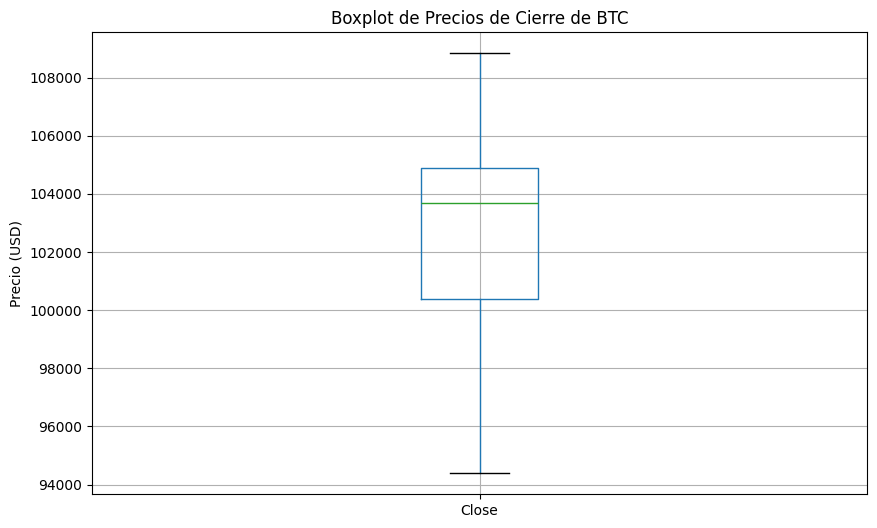

In [10]:
#Muestra el boxplot de la base sin tratamiento
plt.figure(figsize=(10,6))
df_bitcoin.boxplot(column=['Close'])
plt.title('Boxplot de Precios de Cierre de BTC')
plt.ylabel('Precio (USD)')
plt.show()

## 3.3 Función para la limpieza de los datos de Bitcoin

In [11]:
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

    # Número inicial de datos
    num_datos_inicial = df_bitcoin.shape[0]
    print(f"Número inicial de datos: {num_datos_inicial}")

    # Copiar el DataFrame original para no modificarlo directamente
    df_bitcoin_limpio = df_bitcoin.copy()

    # Paso 1: Eliminar los índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
    print(f"Duplicados eliminados: {num_datos_inicial - df_bitcoin_limpio.shape[0]}")

    # Paso 2: Rellenar valores nulos en la columna 'Close con el último valor válido
    df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].ffill()

    # Eliminación de filas con volumen menor o igual a cero:
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Cálculo del rango intercuartil (IQR)
    Q1 = np.quantile(df_bitcoin_limpio['Close'], 0.25)
    Q3 = np.quantile(df_bitcoin_limpio['Close'], 0.75)
    IQR = Q3 - Q1
    print(f'Límites de eliminación de outliers: Inferior={Q1 - 1.5*IQR}, Superior={Q3 + 1.5*IQR}')

    # Eliminación de Outliers
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= (Q1 - 1.5*IQR)) & (df_bitcoin_limpio['Close'] <= (Q3 + 1.5*IQR))]

    # Cálculo del precio promedio de Bitcoin después de la limpieza
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    # Número final de datos
    # print(f"Número de registros antes de la limpieza: {df_bitcoin.shape[0]}")
    print(f"Número final de datos: {df_bitcoin_limpio.shape[0]}")
    print(f"Datos eliminados durante la limpieza: {df_bitcoin.shape[0] - df_bitcoin_limpio.shape[0]}")

## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

Número inicial de datos: 1344
Duplicados eliminados: 0
Límites de eliminación de outliers: Inferior=92704.3056640625, Superior=111849.5322265625
Número final de datos: 824
Datos eliminados durante la limpieza: 520


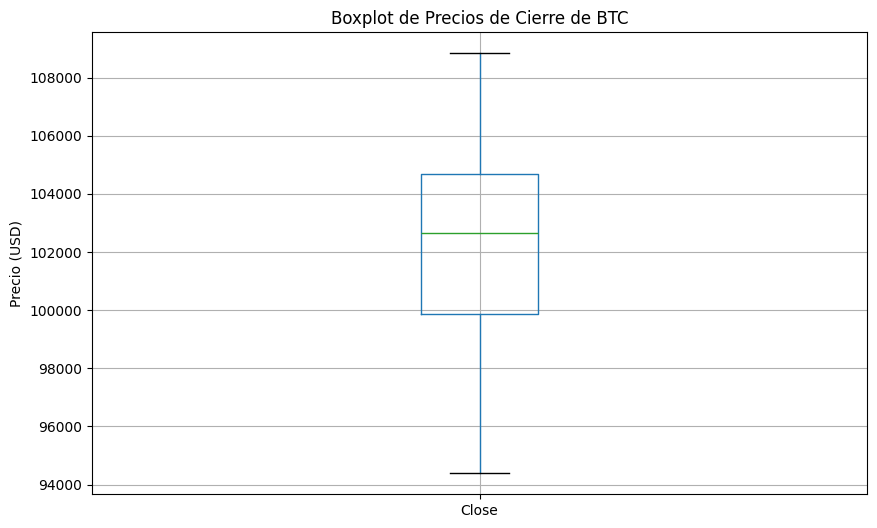

In [12]:
limpieza_datos()

#Muestra el Boxplot del a base limpia
plt.figure(figsize=(10,6))
df_bitcoin_limpio.boxplot(column=['Close'])
plt.title('Boxplot de Precios de Cierre de BTC')
plt.ylabel('Precio (USD)')
plt.show()

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

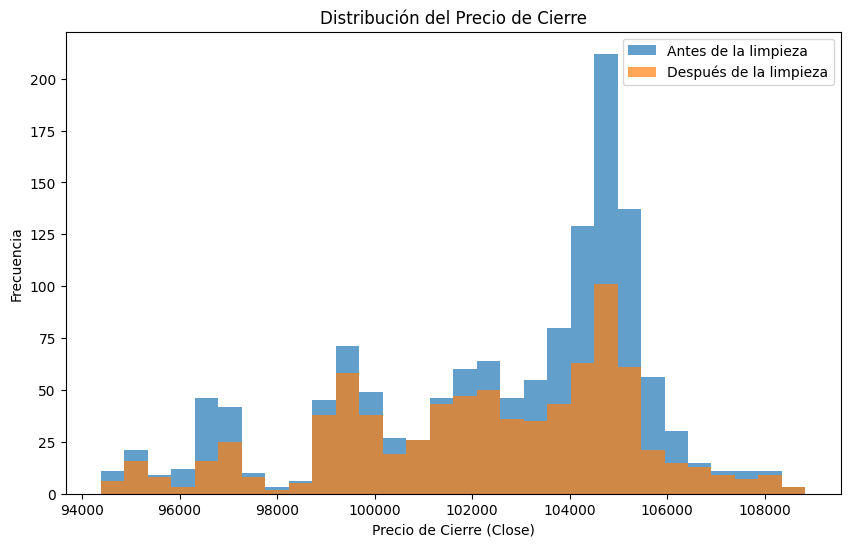

In [13]:
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10,6))
plt.hist(df_bitcoin['Close'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias moviles

In [14]:
def calcular_sma():
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (por ejemplo, 10 periodos)
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (por ejemplo, 50 periodos)
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()

calcular_sma()

In [15]:
df_bitcoin_limpio

,Close,High,Low,Open,Volume,SMA_corto,SMA_largo
Datetime,,,,,,,
2025-01-14 00:00:00,94386.539062,94510.078125,94373.992188,94510.078125,13246464,NaN,NaN
2025-01-14 00:15:00,94592.734375,94797.039062,94434.601562,94434.601562,333963264,NaN,NaN
2025-01-14 01:00:00,94950.031250,94950.031250,94507.414062,94507.414062,112689152,NaN,NaN
2025-01-14 01:15:00,94986.164062,94986.164062,94689.125000,94931.539062,2785280,NaN,NaN
2025-01-14 01:30:00,94679.875000,94904.546875,94679.875000,94904.546875,71016448,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-27 21:45:00,101373.218750,101448.734375,100986.500000,100986.500000,377978880,100791.575781,100091.258281
2025-01-27 22:00:00,101484.273438,101619.726562,101365.328125,101365.328125,134209536,100977.233594,100139.599531
2025-01-27 22:15:00,101494.757812,101533.726562,101399.117188,101494.437500,110821376,101166.405469,100182.437031


## 4.2 Evaluar datos y tomar decision

In [16]:
def tomar_decisiones():
    global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    # Obtener los valores más recientes de SMA_corto y SMA_largo
    SMA_corto = df_bitcoin_limpio['SMA_corto'].iloc[-1]
    SMA_largo = df_bitcoin_limpio['SMA_largo'].iloc[-1]

    # Decidir según las condiciones definidas
    if SMA_corto > SMA_largo and tendencia == "Alta":
        algoritmo_decision = "Comprar"
        color = "#00FF00"  # Color verde para la compra
    elif SMA_corto < SMA_largo and tendencia == "Baja":
        algoritmo_decision = "Vender"
        color = "#FF0000"  # Color rojo para la venta
    else:
        algoritmo_decision = "Mantener"
        color = "#000000"  # Color negro para mantener

    # Imprimir los resultados
    print(f"Precio actual: {precio_actual}")
    print(f"SMA Corto: {SMA_corto}")
    print(f"SMA Largo: {SMA_largo}")
    print(f"Tendencia del mercado: {tendencia}")
    print(f"Decisión del algoritmo: {algoritmo_decision}")
    print(f"Color de la señal: {color}")
tomar_decisiones()

Precio actual: 101403.02
SMA Corto: 101500.8125
SMA Largo: 100282.5871875
Tendencia del mercado: baja
Decisión del algoritmo: Mantener
Color de la señal: #000000


# ATENCION
# Recuerden que la tendencia de una hora puede cambiar rápidamente.
# Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

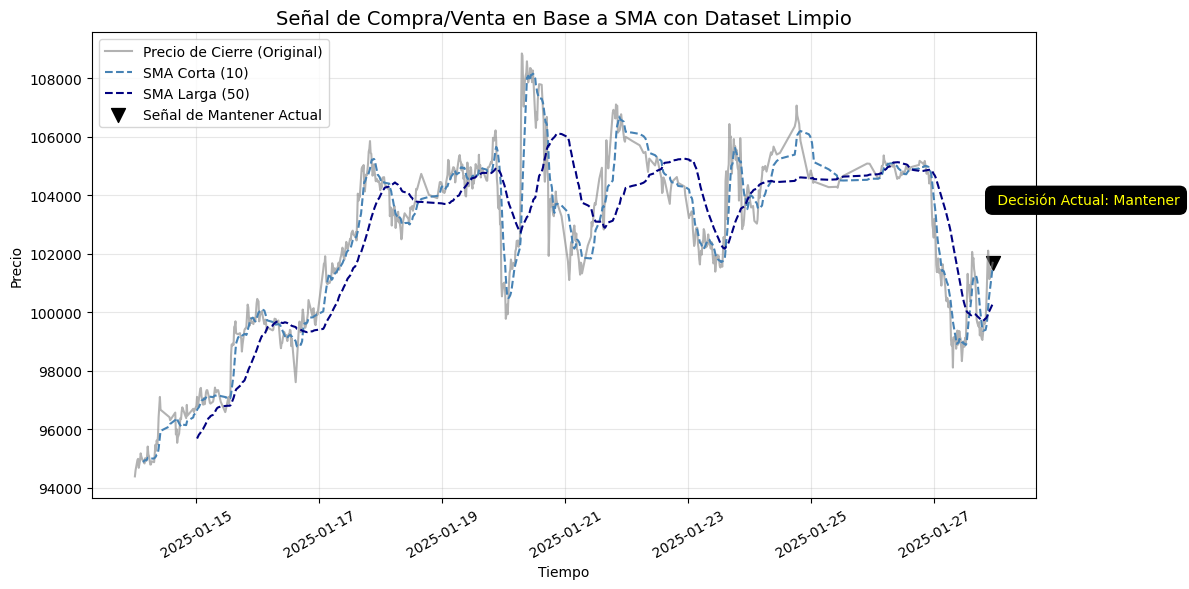

In [17]:
def graficar_senal_actual():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

  # Configuración del gráfico
  plt.figure(figsize=(12, 6))

  # Gráfica del precio de cierre
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close'], label='Precio de Cierre (Original)', color='gray', alpha=0.6)

  # Definir los colores en hexadecimal
  azul_marino = '#000080'
  azul_acero = '#4682B4'

  # Gráficas de las medias móviles
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], label='SMA Corta (10)', linestyle='--', color= azul_acero)
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], label='SMA Larga (50)', linestyle='--', color= azul_marino)

  # Obtener los datos para la última decisión
  ultimo_dato = df_bitcoin_limpio.iloc[-1]
  x_ultima = ultimo_dato.name
  y_ultima = ultimo_dato['Close']

  # Añadir una anotación con la decisión actual
  plt.scatter(x_ultima, y_ultima, color=color, s=100, label=f'Señal de {algoritmo_decision} Actual', marker='v')
  plt.text(x_ultima, y_ultima+2000, f" Decisión Actual: {algoritmo_decision}", fontsize=10,
            color='yellow', bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.5'))

  # Configuración de etiquetas y título
  plt.title('Señal de Compra/Venta en Base a SMA con Dataset Limpio', fontsize=14)
  plt.xlabel('Tiempo')
  plt.ylabel('Precio')
  plt.legend()
  plt.grid(alpha=0.3)

  # Rotar etiquetas del eje X
  plt.xticks(rotation=30)
  plt.tight_layout()

  # Mostrar el gráfico
  plt.show()

# Llamar a la función para graficar
graficar_senal_actual()

# 6. Ciclo

[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_corto', 'SMA_largo'], dtype='object')
Iniciando ciclo de análisis...


Número inicial de datos: 1344
Duplicados eliminados: 0
Límites de eliminación de outliers: Inferior=92704.3056640625, Superior=111849.5322265625
Número final de datos: 824
Datos eliminados durante la limpieza: 520
Precio actual: 101403.02
SMA Corto: 101500.8125
SMA Largo: 100282.5871875
Tendencia del mercado: baja
Decisión del algoritmo: Mantener
Color de la señal: #000000


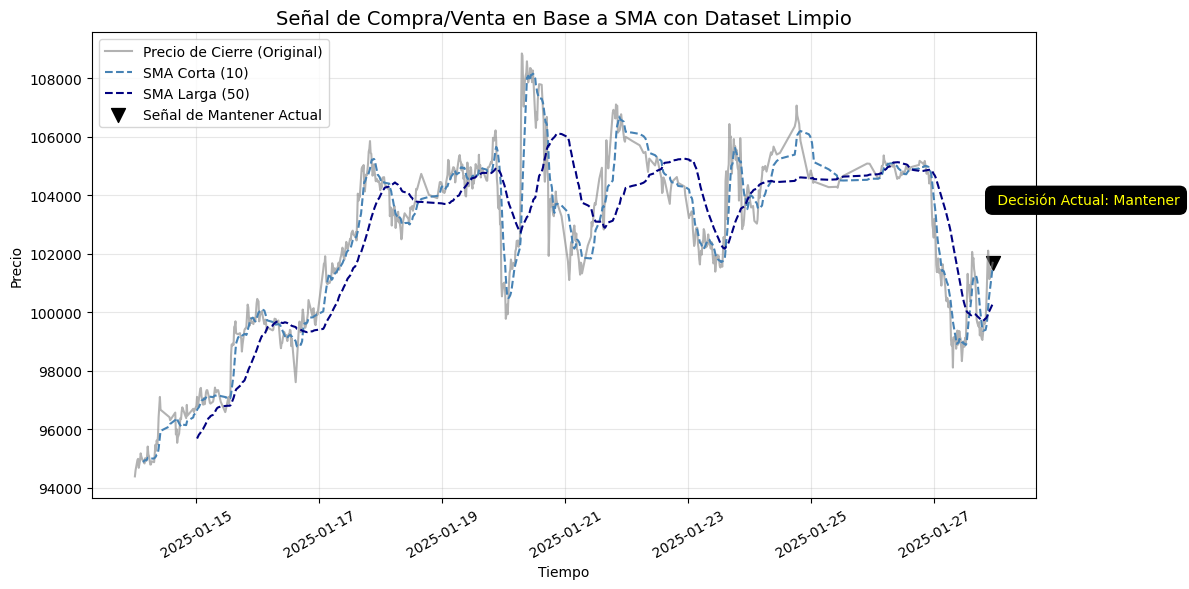

Esperando 5 minutos antes de la siguiente decisión...


[*********************100%***********************]  1 of 1 completed

Iniciando ciclo de análisis...


Número inicial de datos: 1344
Duplicados eliminados: 0
Límites de eliminación de outliers: Inferior=92704.3056640625, Superior=111849.5322265625
Número final de datos: 824
Datos eliminados durante la limpieza: 520
Precio actual: 101383.41
SMA Corto: 101500.8125
SMA Largo: 100282.5871875
Tendencia del mercado: baja
Decisión del algoritmo: Mantener
Color de la señal: #000000


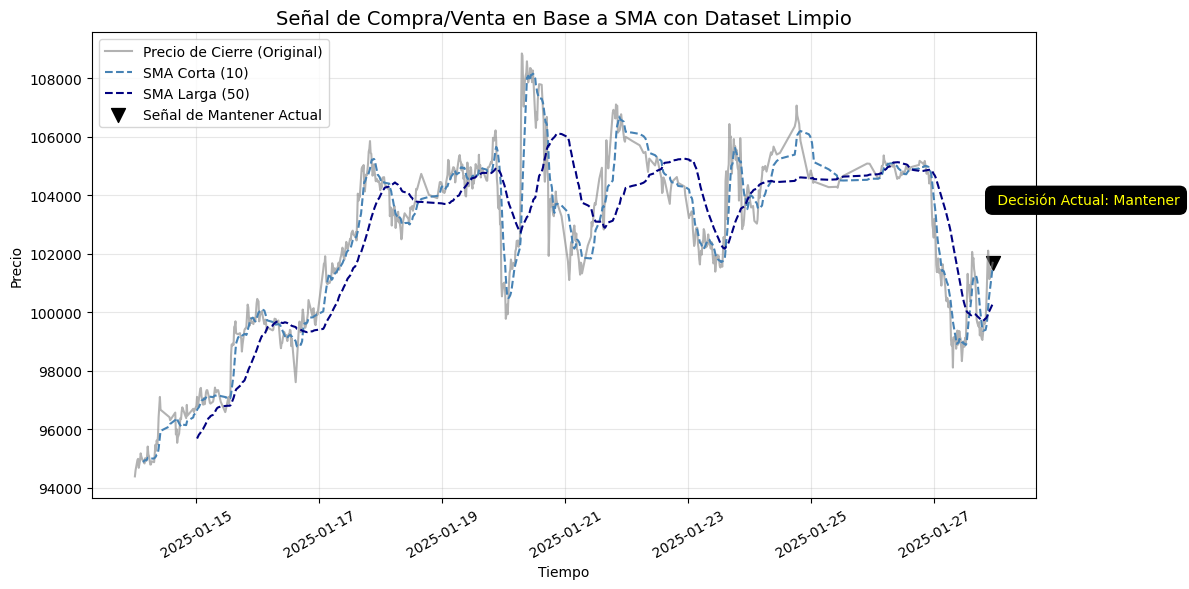

Esperando 5 minutos antes de la siguiente decisión...


In [ ]:
# Verificar las columnas
print(df_bitcoin_limpio.columns)

# Iniciar el bucle
while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma()

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones()

    # Paso 4: Graficar las tendencias y señales
    graficar_senal_actual()

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(60)